# Imports

In [1]:
import itertools
import numpy as np
import os
import pandas as pd
import plotnine as gg
from statsmodels.formula.api import ols
from scipy.stats import spearmanr
import seaborn as sns
gg.theme_set(gg.theme_classic)

In [2]:
from Functions import get_ages_cols, get_param_names, get_category_dict

## Directories etc.

In [3]:
data_save_path = "C:/Users/maria/MEGAsync/SLCNdata/Meta/all_data"
plot_save_path = "C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots"
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

# Get data

In [4]:
ages_cols = get_ages_cols()
param_names = get_param_names()
category_dict = get_category_dict()

In [5]:
all_data = pd.read_csv(os.path.join(data_save_path, 'all_data.csv'), index_col=0)
all_data_z = pd.read_csv(os.path.join(data_save_path, 'all_data_z.csv'), index_col=0)
all_data_long = pd.read_csv(os.path.join(data_save_path, 'all_data_long.csv'), index_col=0)
all_data_long_z = pd.read_csv(os.path.join(data_save_path, 'all_data_long_z.csv'), index_col=0)

## Are parameters correlated across tasks?

### Is there an effect of parameter in a regression that also has age?

In [6]:
pt_dat = pd.DataFrame()

all_data['PreciseYrs2'] = np.square(all_data['PreciseYrs'])
ages_cols += ['PreciseYrs2']

for category, feature_names in category_dict.items():
    for outcome in feature_names:
        for predictor in [p for p in feature_names if p != outcome]:

            # Run full regression
            formula = '{} ~ PreciseYrs + PreciseYrs2 + {}'.format(outcome, predictor)
            fit = ols(data=all_data, formula=formula).fit()

            # Get p and t regression values
            p = pd.DataFrame(fit.pvalues, columns=['p']).reset_index()
            t = pd.DataFrame(fit.tvalues, columns=['t']).reset_index()
            row = p.merge(t)
            row['outcome_task'] = outcome[:2]
            row['formula'] = formula
            row['predictor_task'] = predictor[:2]
            row['category'] = category

            pt_dat = pt_dat.append(row)

pt_dat = pt_dat.rename(columns={'index': 'predictor'})
# pt_dat.outcome = pt_dat.outcome.apply(lambda x : x[:2])
pt_dat.predictor = pt_dat.predictor.apply(lambda x : x.split('_')[-1])
pt_dat['size'] = pt_dat.p.apply(lambda x : 3 if x < 0.001 else (2 if x < 0.05 else (1 if x < 0.1 else 0)))
pt_dat['coarse_predictor'] = pt_dat.predictor.apply(lambda x : x if x in ['PreciseYrs', 'PreciseYrs2', 'Intercept'] else 'Measure')
pt_dat

,predictor,p,t,outcome_task,formula,predictor_task,category,size,coarse_predictor
0,Intercept,2.683932e-11,6.986915,rl,rl_miss ~ PreciseYrs + PreciseYrs2 + bf_miss,bf,miss,3,Intercept
1,PreciseYrs,1.348438e-08,-5.880025,rl,rl_miss ~ PreciseYrs + PreciseYrs2 + bf_miss,bf,miss,3,PreciseYrs
2,PreciseYrs2,4.290604e-07,5.197069,rl,rl_miss ~ PreciseYrs + PreciseYrs2 + bf_miss,bf,miss,3,PreciseYrs2
3,miss,2.442187e-01,1.167336,rl,rl_miss ~ PreciseYrs + PreciseYrs2 + bf_miss,bf,miss,0,Measure
0,Intercept,3.096761e-09,6.153832,rl,rl_miss ~ PreciseYrs + PreciseYrs2 + ps_miss,ps,miss,3,Intercept
...,...,...,...,...,...,...,...,...,...
3,reward,3.430104e-16,8.758824,ps,ps_p_switch ~ PreciseYrs + PreciseYrs2 + ps_p_...,ps,Bayes,3,Measure
0,Intercept,6.720568e-61,22.358310,ps,ps_p_reward ~ PreciseYrs + PreciseYrs2 + ps_p_...,ps,Bayes,3,Intercept
1,PreciseYrs,8.318133e-01,-0.212605,ps,ps_p_reward ~ PreciseYrs + PreciseYrs2 + ps_p_...,ps,Bayes,0,PreciseYrs
2,PreciseYrs2,7.853021e-01,0.272717,ps,ps_p_reward ~ PreciseYrs + PreciseYrs2 + ps_p_...,ps,Bayes,0,PreciseYrs2


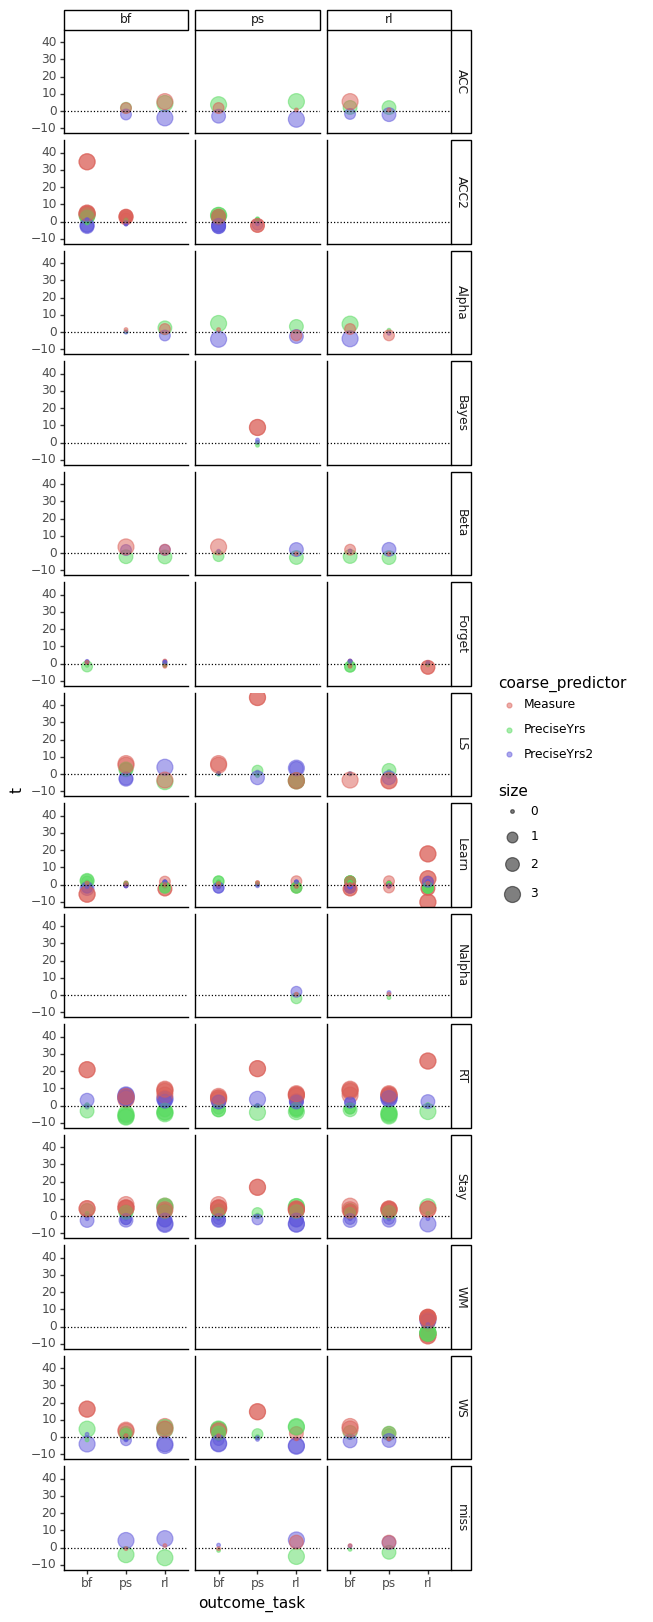

<ggplot: (98002272964)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 5 x 20 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\7_PredictMeasuresFromMeasuresAndAge.png


In [7]:
# At most marginal effects of one parameter on another; largest effect is of age
dat = pt_dat.loc[np.invert(pt_dat.predictor.isin(['Intercept']))]

gg.options.figure_size = (5, 20)
g = (gg.ggplot(dat, gg.aes('outcome_task', 't', color='coarse_predictor', size='size'))
 + gg.geom_point(alpha=0.5)
 + gg.geom_hline(yintercept=0, linetype='dotted')
 + gg.facet_grid('category ~ predictor_task', scales='free_x')
)
print(g)
g.save(os.path.join(plot_save_path, '7_PredictMeasuresFromMeasuresAndAge.png'))

### Are age-cleaned residuals correlated?

In [8]:
resid_dat = pd.DataFrame()

for outcome in [c for c in all_data.columns.values if not c in ages_cols]:
    
    # Run regression
    formula = '{} ~ PreciseYrs + PreciseYrs2'.format(outcome)
    fit = ols(data=all_data, formula=formula).fit()

    # Get residuals
    resid_row = pd.DataFrame(fit.resid).T
    resid_row.index = ['resid_{}'.format(outcome)]

    resid_dat = resid_dat.append(resid_row)

resid_dat = resid_dat.T
resid_dat['ID'] = all_data['ID']
# all_data = all_data.merge(resid_dat)
resid_dat

,resid_bf_ACC,resid_bf_RT,resid_bf_RTsd,resid_bf_ACC_delta,resid_bf_RT_delta,resid_bf_miss,resid_rl_ACC,resid_rl_RT,resid_rl_RTsd,resid_rl_ACC_delta,...,resid_ps_criterion_trial,resid_bf_ACC_first3trials,resid_bf_asymptote,resid_bf_learning_slope,resid_bf_intercept,resid_bf_prew,resid_bf_delay,resid_ps_1_over_beta,resid_ps_persev,ID
0,-0.082948,-0.135320,-0.235502,-0.420387,-0.263166,-0.015932,0.083125,0.160540,0.221012,0.013462,...,-0.161200,-0.169667,-0.123448,2.014237,-0.690201,-0.780778,0.022189,0.212879,-0.110838,17
1,0.065899,-0.100113,-0.199361,0.239302,-0.200051,-0.007353,0.066750,-0.121527,-0.159208,-0.041155,...,0.288939,-0.291964,0.165734,-0.826841,0.512821,0.524521,0.032691,-0.064341,0.056746,18
2,0.084766,-0.231477,-0.138209,0.151000,0.146113,-0.004271,0.096858,-0.165135,-0.191062,-0.074661,...,0.028152,-0.056877,0.153865,-0.747229,0.755217,0.578672,-0.007295,-0.221293,0.110241,20
3,-0.057486,0.351712,0.429730,0.016418,-0.211434,-0.001807,-0.026517,0.101444,0.119488,-0.023492,...,0.246709,-0.152947,-0.031087,-0.683333,-0.597875,-0.288928,0.004630,0.204720,0.014949,22
4,0.109929,0.270119,0.063945,0.001852,-0.036285,-0.010105,0.126273,-0.057454,0.023049,-0.006826,...,-0.184950,0.137502,0.111587,-0.004502,0.285361,0.088280,-0.044858,0.059822,-0.055106,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,-0.088167,0.048911,-0.007106,0.111979,0.154921,0.001433,-0.006100,-0.100733,-0.149895,0.138314,...,-0.424401,0.073988,-0.132255,4.730247,-0.782342,-0.291109,0.045651,-0.089904,0.106988,465
243,-0.213190,-0.216063,-0.219320,-0.140632,-0.096472,0.000923,0.022922,-0.074491,-0.050092,-0.101034,...,-0.290221,-0.003158,-0.253635,-0.602885,-1.383339,-0.691365,-0.060143,-0.137161,-0.086963,466
244,-0.012627,0.177235,0.274061,-0.214626,0.169972,0.000185,0.039043,0.166027,0.376619,-0.053718,...,-0.029713,0.168767,-0.067033,0.487276,-0.611392,-0.703570,0.056758,-0.044790,-0.092082,467
245,-0.112045,1.055248,1.006676,-0.189069,0.556518,0.001400,-0.017155,0.075097,0.196937,-0.029850,...,0.951711,-0.091595,-0.150914,0.561833,-1.067192,-0.755859,0.070092,-0.015122,0.146433,468


In [25]:
# resid_params = ['resid_{}'.format(p) for p in [
#     'rl_log_nalpha', 'bf_nalpha', 'ps_nalpha', 
#     'rl_log_alpha', 'bf_alpha', 'ps_alpha', 
#     'rl_epsilon_1_over_beta', 'bf_1_over_beta', 'ps_1_over_beta', 
# ]]
params = [
    'rl_log_nalpha', 'ps_nalpha', 
    'rl_log_alpha', 'bf_alpha', 'ps_alpha', 
    'rl_epsilon_1_over_beta', 'bf_1_over_beta', 'ps_1_over_beta', 
]
resid_params = ['resid_{}'.format(p) for p in params]

resid_features = [c for c in resid_dat.columns.values if 'resid' in c]
features = [f[6:] for f in resid_features]

r_dat_resid = pd.DataFrame()
r_dat = pd.DataFrame()

for param, resid_param in zip(params, resid_params):
    for feat, resid_feat in zip(features, resid_features):
        
        resid_row = pd.DataFrame({
            'r': [spearmanr(resid_dat[resid_param], resid_dat[resid_feat]).correlation],
            'p': [spearmanr(resid_dat[resid_param], resid_dat[resid_feat]).pvalue],
            'param': [resid_param],
            'feat': [resid_feat]
        })
        row = pd.DataFrame({
            'r': [spearmanr(all_data_z[param], all_data_z[feat]).correlation],
            'p': [spearmanr(all_data_z[param], all_data_z[feat]).pvalue],
            'param': [param],
            'feat': [feat]
        })
        
        r_dat_resid = r_dat_resid.append(resid_row)
        r_dat = r_dat.append(row)
        
p_sig = 0.0001
r_dat_resid['r_sig'] = r_dat_resid.apply(lambda x : (1 + x.r) / 2 if x.p < p_sig else 0.5, axis=1)  # Get on [0, 1] for plotting; use 0.5 instead np.nan to get nice white color (instead of ugly grey)
r_dat_resid = r_dat_resid.reset_index()
r_dat['r_sig'] = r_dat.apply(lambda x : (1 + x.r) / 2 if x.p < p_sig else 0.5, axis=1)  # Get on [0, 1] for plotting; use 0.5 instead np.nan to get nice white color (instead of ugly grey)
r_dat = r_dat.reset_index()

r_dat_resid

,index,r,p,param,feat,r_sig
0,0,-0.016238,7.995538e-01,resid_rl_log_nalpha,resid_bf_ACC,0.500000
1,0,0.080261,2.087406e-01,resid_rl_log_nalpha,resid_bf_RT,0.500000
2,0,0.065439,3.056759e-01,resid_rl_log_nalpha,resid_bf_RTsd,0.500000
3,0,-0.022254,7.278255e-01,resid_rl_log_nalpha,resid_bf_ACC_delta,0.500000
4,0,0.031632,6.207835e-01,resid_rl_log_nalpha,resid_bf_RT_delta,0.500000
...,...,...,...,...,...,...
491,0,-0.244438,1.039409e-04,resid_ps_1_over_beta,resid_bf_intercept,0.500000
492,0,-0.320642,2.599902e-07,resid_ps_1_over_beta,resid_bf_prew,0.339679
493,0,0.173312,6.320232e-03,resid_ps_1_over_beta,resid_bf_delay,0.500000
494,0,1.000000,0.000000e+00,resid_ps_1_over_beta,resid_ps_1_over_beta,1.000000


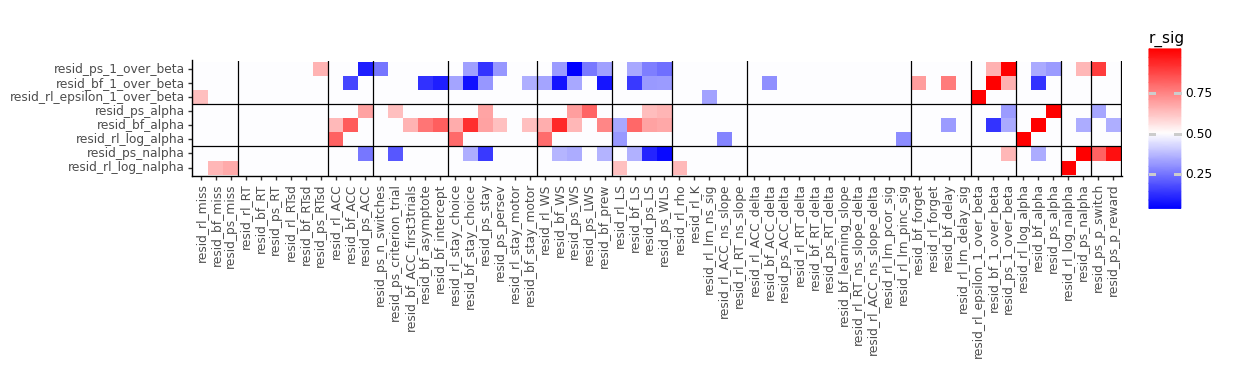

<ggplot: (98003836167)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 12 x 1.5 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\7_ResidParameterMeasureCorrelations_p0.0001.png


In [26]:
gg.options.figure_size = (12, 1.5)

# Get order of features on x-axis [x_ticks]; and get separating bars [vlines]
x_ticks = []
vlines = []
new_line = 0.5
for cols in category_dict.values():
    x_ticks += cols
    new_line += len(cols)
    vlines += [new_line]

# Plot
g_resid = (gg.ggplot(r_dat_resid, gg.aes('feat', 'param', fill='r_sig'))
     + gg.geom_tile()
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
#      + gg.theme(legend_position='none')
     + gg.geom_hline(yintercept=[2.5, 5.5])
     + gg.geom_vline(xintercept=vlines)
     + gg.labs(x='', y='')
     + gg.scale_x_discrete(limits=['resid_{}'.format(t) for t in x_ticks])
     + gg.scale_y_discrete(limits=resid_params)
     + gg.scale_fill_gradientn(colors=["blue", "white", "red"], values=[0, 0.47, 1])  # for some reason, I need to set the middle value ot 0.47 (instead of 0.5) to get the white of non-significant values appear white
    )
print(g_resid)
g_resid.save(os.path.join(plot_save_path, '7_ResidParameterMeasureCorrelations_p{}.png'.format(p_sig)))

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\scales\scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\scales\scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



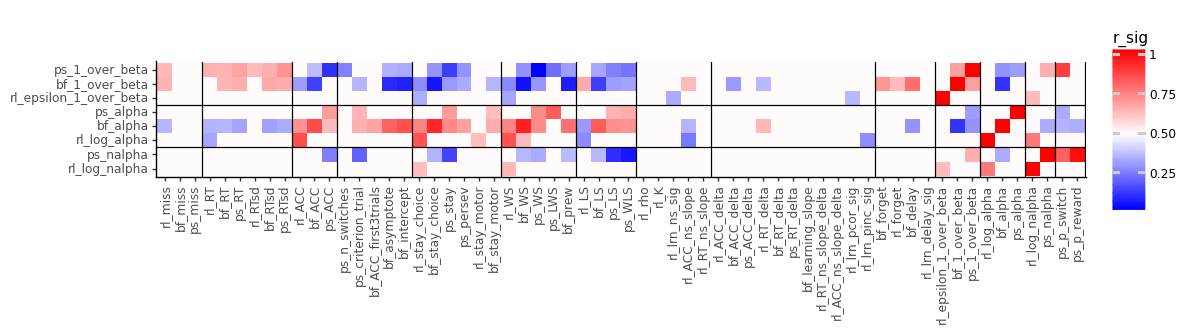

<ggplot: (98003763881)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 12 x 1.5 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\7_ParameterMeasureCorrelations_p0.0001.png


In [27]:
g = (g_resid
     + gg.scale_y_discrete(limits=params)
     + gg.scale_x_discrete(limits=x_ticks)
    )
g.data = r_dat
print(g)
g.save(os.path.join(plot_save_path, '7_ParameterMeasureCorrelations_p{}.png'.format(p_sig)))

### Plot scatter plots for all correlations

In [ ]:
# TODO: Both are too slow...
print(sns.pairplot(resid_dat[resid_dat.columns[:10]]))
# print(pd.plotting.scatter_matrix(resid_dat[['resid_bf_ACC', 'resid_bf_RT', 'resid_bf_RTsd']]))

In [ ]:
# gg.options.figure_size = (2, 2)

# for param_name, params in category_dict.items():
#     resid_params = ['resid_{}'.format(p) for p in params]
#     param_combos = itertools.combinations(resid_params, 2)
#     for p1, p2 in param_combos:
#         print(spearmanr(all_data[p1], all_data[p2]))
#         print(gg.ggplot(all_data, gg.aes(p1, p2))
#               + gg.geom_point(size=0.2)
#               + gg.stat_smooth(method='lm', color='green')
#               + gg.geom_smooth(color='red')
# #               + gg.labs(x=p1)
#         )

In [ ]:
# gg.options.figure_size = (2, 2)

# wanted_params = [
#     'resid_ps_alpha', 'resid_bf_alpha', 'resid_rl_log_alpha',
#     'resid_ps_nalpha', 'resid_bf_nalpha', 'resid_rl_log_nalpha',
#     'resid_bf_1_over_beta', 'resid_rl_epsilon_1_over_beta', 'resid_ps_1_over_beta',
# ]
# wanted_measures = [c for c in all_data.columns.values if 'resid' in c]

# for p1 in wanted_params:
#     for p2 in wanted_measures:
#         print(p1, p2)
#         print(spearmanr(all_data[p1], all_data[p2]))
#         print(gg.ggplot(all_data, gg.aes(p1, p2))
#               + gg.geom_point(size=0.2)
#               + gg.stat_smooth(method='lm', color='green')
#               + gg.geom_smooth(color='red')
#     #               + gg.labs(x=p1)
#         )

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
